The following python code will use the OS library to use Operating System libraries, giving you access to the file system, and the zipfile library allowing you to unzip the data.

In [3]:
import os
import zipfile

local_zip = 'Img.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('./Img')
zip_ref.close()

In [4]:
# Directory with our training horse pictures
train_negdata_dir = os.path.join('./Img/Img/negdata')

# Directory with our training human pictures
train_posdata_dir = os.path.join('./Img/Img/posdata')

In [5]:
train_negdata_names = os.listdir(train_negdata_dir)
print(train_negdata_names[:10])

train_posdata_names = os.listdir(train_posdata_dir)
print(train_posdata_names[:10])

['1572485314973923383.jpg', '1572485314975299499.jpg', '1572485314980079224.jpg', '1572485314981558533.jpg', '1572485314982703611.jpg', '1572485314983622377.jpg', '1572485314989158923.jpg', '1572485314990713553.jpg', '1572485314991831368.jpg', '1572485315002324220.jpg']
['1572509110132139863.jpg', '1572509110132994639.jpg', '1572509110134361369.jpg', '1572509110135451727.jpg', '1572509110136463930.jpg', '1572509110137448909.jpg', '1572509110138490944.jpg', '1572509110139376072.jpg', '1572509110140266607.jpg', '1572509110141133217.jpg']


In [6]:
print('total training negetive images:', len(os.listdir(train_negdata_dir)))
print('total training positive images:', len(os.listdir(train_posdata_dir)))

total training negetive images: 1617
total training positive images: 1213


Now let's take a look at a few pictures to get a better sense of what they look like. First, configure the matplot parameters:

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Now, display a batch of 8 neg and 8 pos pictures. You can rerun the cell to see a fresh batch each time:

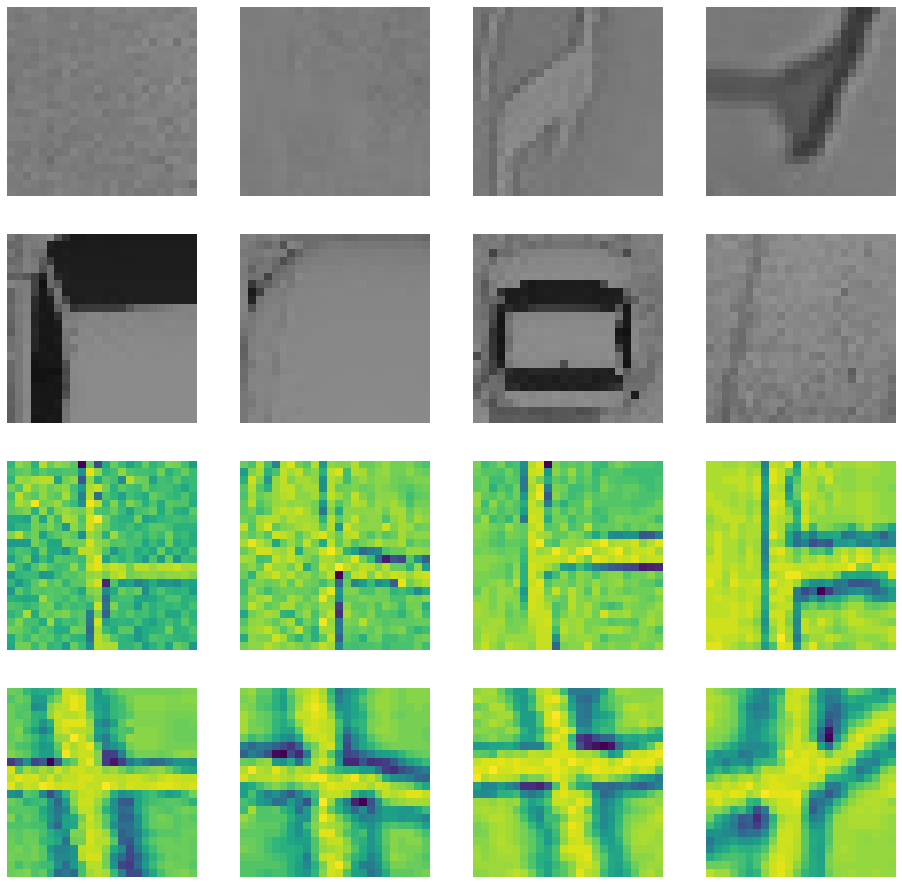

In [8]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_negdata_pix = [os.path.join(train_negdata_dir, fname) 
                for fname in train_negdata_names[pic_index-8:pic_index]]
next_posdata_pix = [os.path.join(train_posdata_dir, fname) 
                for fname in train_posdata_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_negdata_pix+next_posdata_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Building a Small Model from Scratch

But before we continue, let's start defining the model:

Step 1 will be to import tensorflow.

In [9]:
import tensorflow as tf

We then add convolutional layers as in the previous example, and flatten the final result to feed into the densely connected layers.

Finally we add the densely connected layers.

Note that because we are facing a two-class classification problem, i.e. a binary classification problem, we will end our network with a sigmoid activation, so that the output of our network will be a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).

In [10]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

In [11]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/Img/Img/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 150x150
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 2830 images belonging to 2 classes.


In [13]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=8,  
      epochs=15,
      verbose=1)

Epoch 1/15
8/8 [==============================] - 112s 14s/step - loss: 0.7572 - acc: 0.5527
Epoch 2/15
8/8 [==============================] - 98s 12s/step - loss: 0.6857 - acc: 0.5615
Epoch 3/15
8/8 [==============================] - 88s 11s/step - loss: 0.7105 - acc: 0.5396
Epoch 4/15
8/8 [==============================] - 97s 12s/step - loss: 0.6814 - acc: 0.5762
Epoch 5/15
8/8 [==============================] - 101s 13s/step - loss: 0.6481 - acc: 0.5771
Epoch 6/15
8/8 [==============================] - 90s 11s/step - loss: 0.6611 - acc: 0.6132
Epoch 7/15
8/8 [==============================] - 91s 11s/step - loss: 0.6426 - acc: 0.6429
Epoch 8/15
8/8 [==============================] - 97s 12s/step - loss: 0.8052 - acc: 0.6953
Epoch 9/15
8/8 [==============================] - 88s 11s/step - loss: 0.6349 - acc: 0.6593
Epoch 10/15
8/8 [==============================] - 104s 13s/step - loss: 0.6018 - acc: 0.7256
Epoch 11/15
8/8 [==============================] - 101s 13s/step - loss: 0.5

use the model to test a real image, predicting it's a corner image or not

In [32]:
import numpy as np
from keras.preprocessing import image

# predicting images
img1 = image.load_img('./img/predict/capture_screen58.bmp', target_size=(300, 300))
img2 = image.load_img('./img/predict/capture_screen2.bmp', target_size=(300, 300))
x1 = image.img_to_array(img1)
x1 = np.expand_dims(x1, axis=0)
x2 = image.img_to_array(img2)
x2 = np.expand_dims(x2, axis=0)

images1 = np.vstack([x1])
images2 = np.vstack([x2])
classes = model.predict(images1, batch_size=10)
print(classes[0])

if classes[0]>0.5:
    print("predict is a corner" )
else:
    print("predict is not a corner")

[1.]
predict is a corner


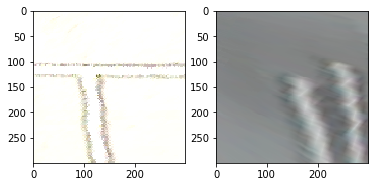

In [36]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(img1)
plt.subplot(1,2,2)
plt.imshow(img2)
plt.show()

## Visualizing Intermediate Representations
To get a feel for what kind of features our convnet has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the convnet.

Let's pick a random image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

D:\Install\anaconda\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


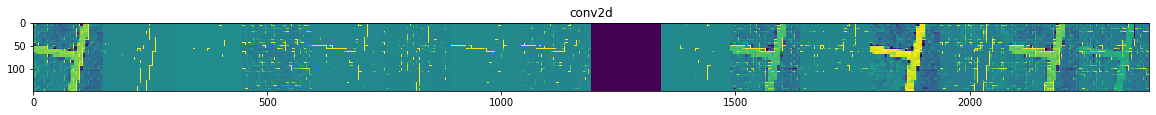

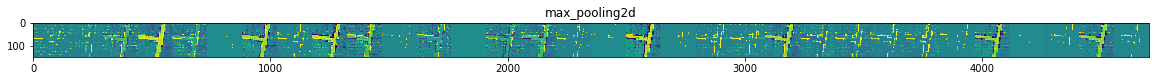

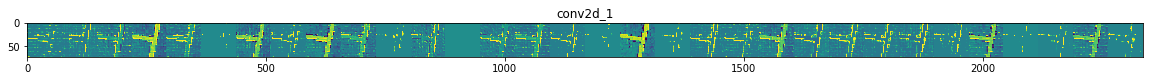

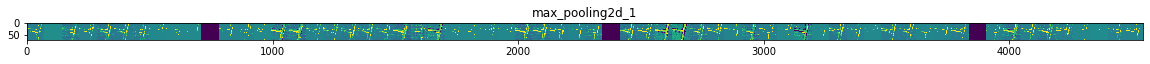

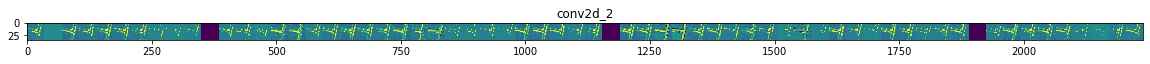

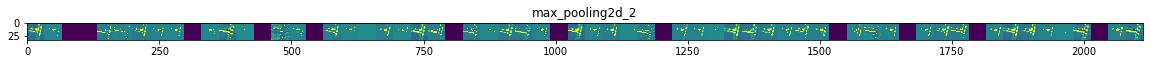

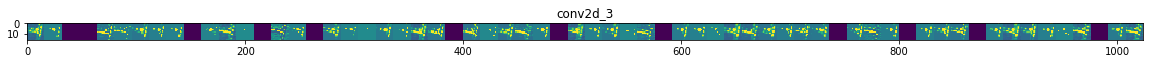

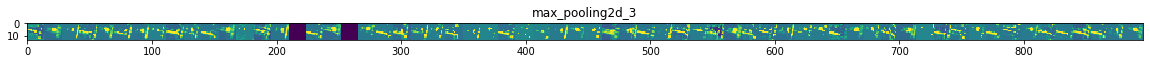

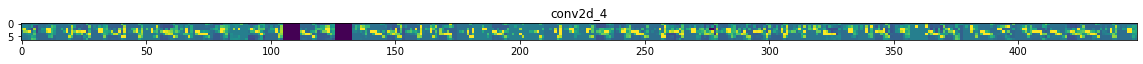

In [39]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
negdata_img_files = [os.path.join(train_negdata_dir, f) for f in train_negdata_names]
posdata_img_files = [os.path.join(train_posdata_dir, f) for f in train_posdata_names]
img_path = random.choice(negdata_img_files + posdata_img_files)

img = load_img(img_path, target_size=(300, 300))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')